In [130]:
import pandas as pd

auto = pd.read_csv("../../data/Auto.csv", na_values='?').dropna().set_index("name")
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86.0,2790,15.6,82,1
vw pickup,44.0,4,97.0,52.0,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84.0,2295,11.6,82,1


In [131]:
med = auto["mpg"].median()

mpg01 = (auto["mpg"] > med).astype(int)
auto["mpg01"] = mpg01

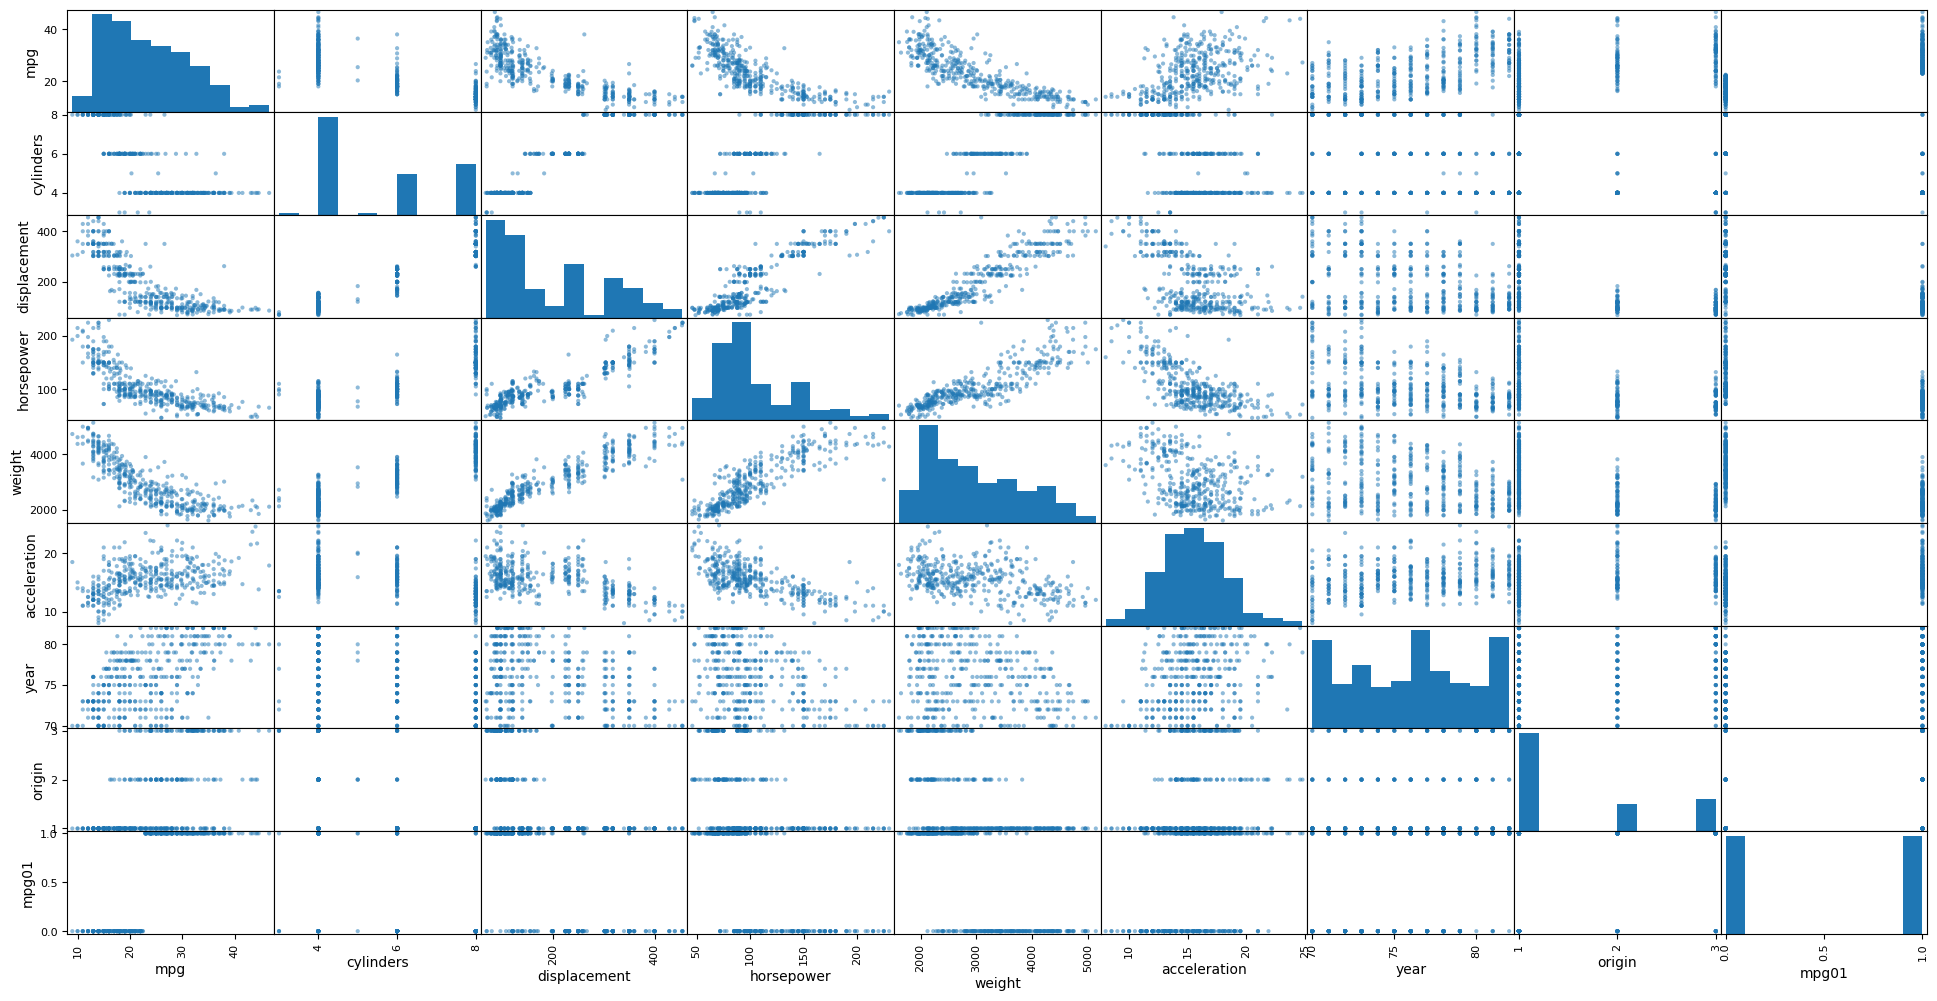

In [132]:
pd.plotting.scatter_matrix(auto, figsize=(24,12));

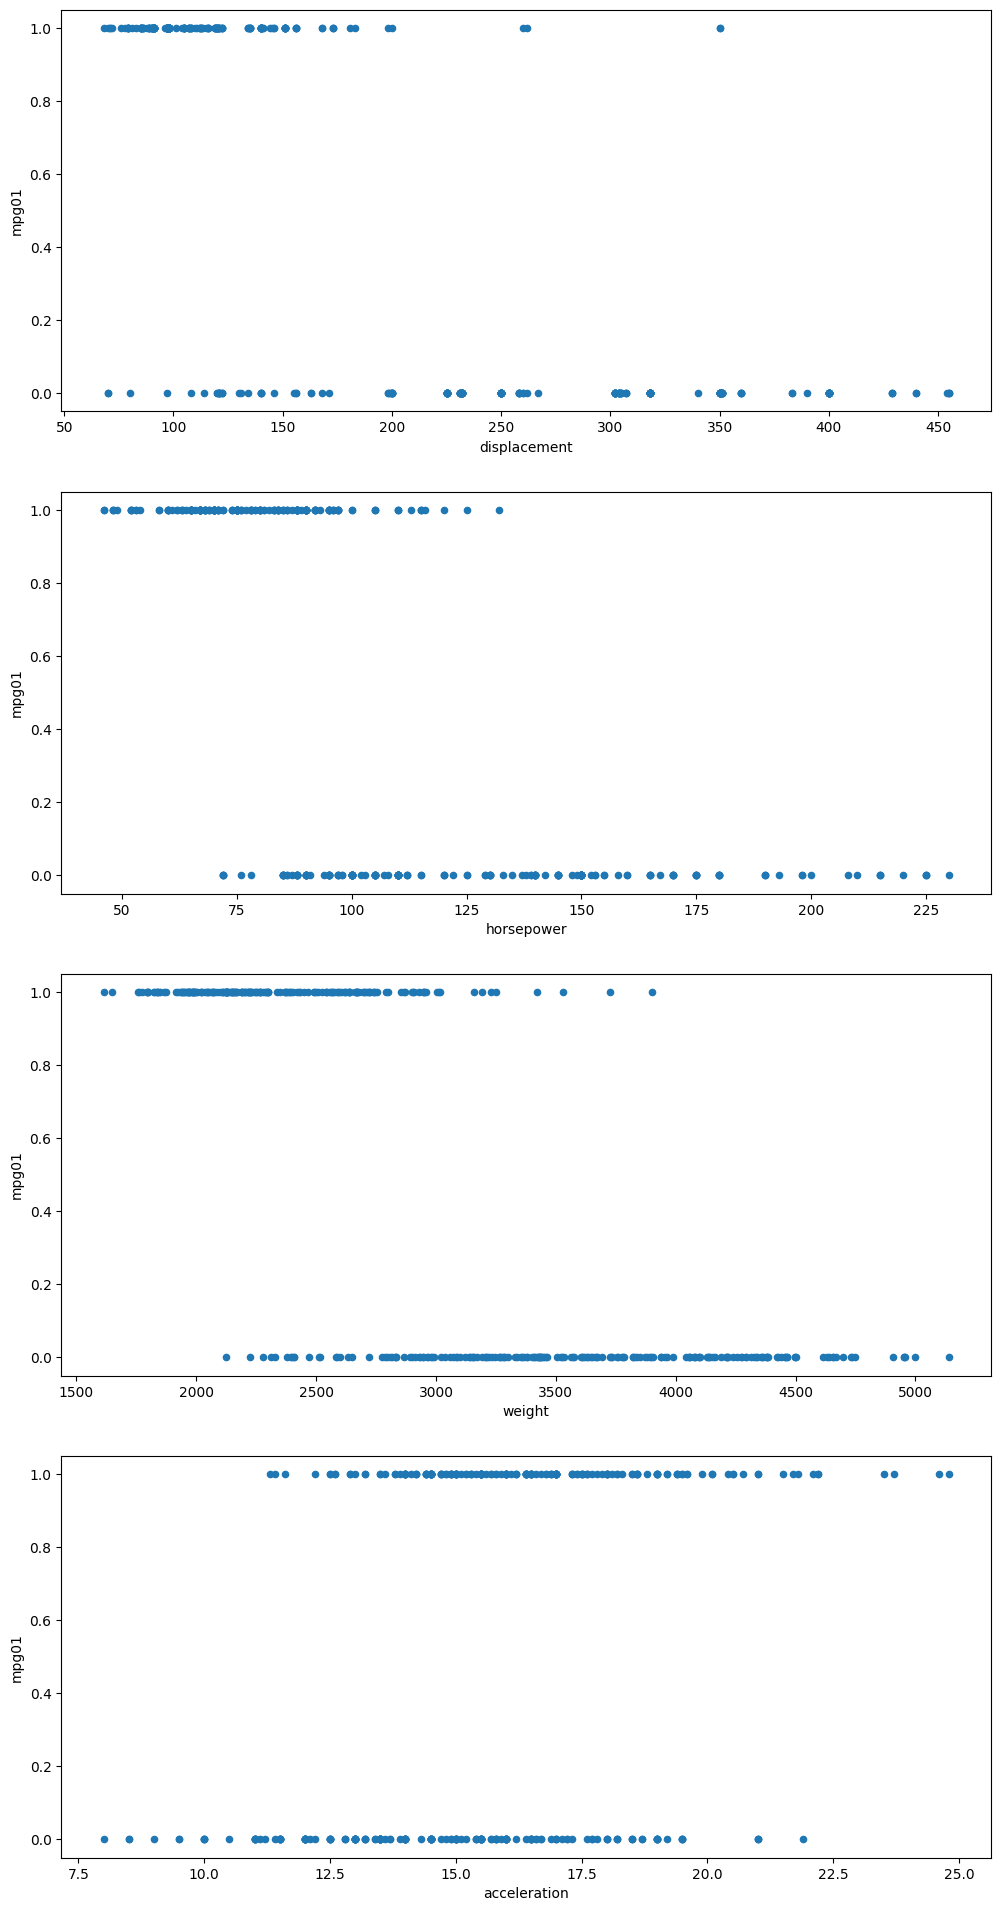

In [133]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 1, figsize=(12, 24))
i = 0

for pred in ("displacement", "horsepower", "weight", "acceleration"):
    auto.plot.scatter(pred, "mpg01", ax=ax[i])
    i+=1

In [134]:
auto[["displacement", "horsepower", "weight", "acceleration", "mpg"]].corr()

,displacement,horsepower,weight,acceleration,mpg
displacement,1.000000,0.897257,0.932994,-0.543800,-0.805127
horsepower,0.897257,1.000000,0.864538,-0.689196,-0.778427
weight,0.932994,0.864538,1.000000,-0.416839,-0.832244
acceleration,-0.543800,-0.689196,-0.416839,1.000000,0.423329
mpg,-0.805127,-0.778427,-0.832244,0.423329,1.000000


Displacement, horsepower, weight, and acceleration all show clear relationships with mpg01. However, since these variables, particularly displacement, horsepower, and weight, are highly correlated with one another, using all of them might introduce multicollinearity. Therefore, it may be more effective to select just one of these predictors to avoid redundancy and improve model interpretability.

In [135]:
def evaluate_confusion_df(confusion_df):
    # Extract values
    TP = confusion_df.loc[1, 1]
    FP = confusion_df.loc[1, 0]
    FN = confusion_df.loc[0, 1]
    TN = confusion_df.loc[0, 0]

    total = TP + FP + FN + TN
    accuracy = (TP + TN) / total if total else 0

    precision_up = TP / (TP + FP) if (TP + FP) else 0
    recall_up = TP / (TP + FN) if (TP + FN) else 0

    precision_down = TN / (TN + FN) if (TN + FN) else 0
    recall_down = TN / (TN + FP) if (TN + FP) else 0

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (1): {precision_up * 100:.2f}%")
    print(f"Recall (1): {recall_up * 100:.2f}%")
    print(f"Precision (0): {precision_down * 100:.2f}%" if (TN + FN) else "Precision (0): Undefined (no 0 predictions)")
    print(f"Recall (0): {recall_down * 100:.2f}%" if (TN + FP) else "Recall (0): Undefined (no actual 0 cases)")

In [136]:
train = auto["year"] < 80

auto_train, auto_test = auto[train], auto[~train]

In [137]:
auto["year"].describe()

count    392.000000
mean      75.979592
std        3.683737
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: year, dtype: float64

In [138]:
from ISLP.models import ModelSpec as MS 

X_train = MS(["weight"]).fit_transform(auto_train)
X_test = MS(["weight"]).fit_transform(auto_test)

y = auto_train["mpg01"] == 1

# LDA

In [139]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA  

lda = LDA()
lda.fit(X_train, y)

prob = lda.predict(X_test)

import numpy as np

labels = np.array([0]*auto_test.shape[0])
labels[prob>0.5] = 1

from ISLP import confusion_table

conf = confusion_table(labels, auto_test["mpg01"])
conf

Truth,0,1
Predicted,,
0,5,14
1,0,66


In [140]:
print("LDA")
evaluate_confusion_df(conf)

LDA
Accuracy: 83.53%
Precision (1): 100.00%
Recall (1): 82.50%
Precision (0): 26.32%
Recall (0): 100.00%


# QDA

In [141]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 

qda = QDA(reg_param=0.1)
qda.fit(X_train, y)

prob = qda.predict(X_test)

labels = np.array([0]*auto_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, auto_test["mpg01"])
conf

Truth,0,1
Predicted,,
0,5,16
1,0,64


In [142]:
print("QDA")
evaluate_confusion_df(conf)

QDA
Accuracy: 81.18%
Precision (1): 100.00%
Recall (1): 80.00%
Precision (0): 23.81%
Recall (0): 100.00%


# Logistic Regression 

In [143]:
import statsmodels.api as sm 

results = sm.GLM(y, X_train, family=sm.families.Binomial()).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  mpg01   No. Observations:                  307
Model:                            GLM   Df Residuals:                      305
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79.441
Date:                Wed, 23 Jul 2025   Deviance:                       158.88
Time:                        18:47:57   Pearson chi2:                     388.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5545
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.7488      1.375      8.545      0.000       9.054      14.444
weight        -0.0044      0.001     -8.547      0.000      -0.005      -0.003
==============================================================================
"""

In [144]:
prob = results.predict(X_test)

labels = np.array([0]*auto_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, auto_test["mpg01"])
conf

Truth,0,1
Predicted,,
0,5,20
1,0,60


In [145]:
print("Logistic Regression")
evaluate_confusion_df(conf)

Logistic Regression
Accuracy: 76.47%
Precision (1): 100.00%
Recall (1): 75.00%
Precision (0): 20.00%
Recall (0): 100.00%


# Naive Bayes

In [146]:
from sklearn.naive_bayes import GaussianNB as NB

nb = NB()
nb.fit(X_train, y)

prob = nb.predict(X_test)

labels = np.array([0]*auto_test.shape[0])
labels[prob>0.5] = 1

conf = confusion_table(labels, auto_test["mpg01"])
conf

Truth,0,1
Predicted,,
0,5,16
1,0,64


In [147]:
print("Naive Bayes")
evaluate_confusion_df(conf)

Naive Bayes
Accuracy: 81.18%
Precision (1): 100.00%
Recall (1): 80.00%
Precision (0): 23.81%
Recall (0): 100.00%


# KNN (25)

In [148]:
from sklearn.neighbors import KNeighborsClassifier as KNN 

knn = KNN(n_neighbors=25) #25 is picked from the graph bellow
knn.fit(X_train, y)

prob = knn.predict(X_test)

labels = np.array([0]*auto_test.shape[0])
labels[prob>0.5] = 1

from ISLP import confusion_table

conf = confusion_table(labels, auto_test["mpg01"])
conf

Truth,0,1
Predicted,,
0,5,14
1,0,66


In [149]:
print("KNN (25)")
evaluate_confusion_df(conf)

KNN (25)
Accuracy: 83.53%
Precision (1): 100.00%
Recall (1): 82.50%
Precision (0): 26.32%
Recall (0): 100.00%


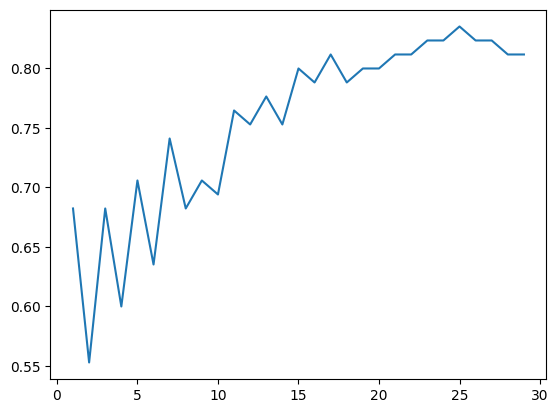

In [150]:
accuracies = []

for i in range(1, 30):
    knn = KNN(n_neighbors=i)

    knn.fit(X_train, y)

    labels = knn.predict(X_test)
    labels = np.where(labels, 1, 0)

    accuracies.append(np.mean(labels == auto_test["mpg01"]))

import matplotlib.pyplot as plt

x_knn = range(1, 30)

fig, ax = plt.subplots()

ax.plot(x_knn, accuracies);

The results across all models, LDA, QDA, logistic regression, Naive Bayes, and KNN (with $K=25$), are identical, which is unusual and suggests that **weight** alone is such a strong predictor of **mpg01** that it dominates the classification task. Each model achieves 83.53% accuracy, with perfect precision (100%) for predicting high-MPG cars (class 1) and a high recall (82.5%) for that class. However, performance on low-MPG cars (class 0) is weak, with a recall of 100% but a very low precision of 26.32%, indicating many false positives. This imbalance suggests that while **weight** is highly informative, relying on it alone limits the model’s ability to distinguish low-MPG vehicles accurately. To improve precision on that class, it would be beneficial to incorporate additional predictors or engineer features that capture more nuanced relationships.